Tensorflow version: 2.16.1
GPU Available: True
Train: 2451, Valid: 306, Test: 307
Epoch 1/100


I0000 00:00:1732967030.827518     157 service.cc:145] XLA service 0x7e5664006680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732967030.827575     157 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732967030.827580     157 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732967067.487197     208 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_497', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732967070.952645     206 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_521', 256 bytes spill stores, 256 bytes spill loads

I0000 00:00:1732967073.473306     207 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_497', 968 bytes spill stores, 924 bytes spill loads

I0000 00:00:173296

306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7274 - dice_coef: 0.0775 - loss: 0.9225

I0000 00:00:1732967248.646843     284 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_521', 256 bytes spill stores, 256 bytes spill loads

I0000 00:00:1732967252.267260     281 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_75', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1732967300.212593     156 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_77', 80 bytes spill stores, 80 bytes spill loads



307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7278 - dice_coef: 0.0776 - loss: 0.9224

I0000 00:00:1732967318.132112     334 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_110', 256 bytes spill stores, 256 bytes spill loads




Epoch 1: val_loss improved from inf to 0.92759, saving model to output/best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 332s 599ms/step - accuracy: 0.7281 - dice_coef: 0.0777 - loss: 0.9223 - val_accuracy: 0.5834 - val_dice_coef: 0.0715 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 2/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9680 - dice_coef: 0.2047 - loss: 0.7953
Epoch 2: val_loss did not improve from 0.92759
307/307 ━━━━━━━━━━━━━━━━━━━━ 44s 143ms/step - accuracy: 0.9680 - dice_coef: 0.2048 - loss: 0.7952 - val_accuracy: 0.9830 - val_dice_coef: 0.0041 - val_loss: 0.9958 - learning_rate: 0.0010
Epoch 3/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9776 - dice_coef: 0.2843 - loss: 0.7157
Epoch 3: val_loss improved from 0.92759 to 0.90018, saving model to output/best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9776 - dice_coef: 0.2844 - loss: 0.7156 - val_accuracy: 0.7435 - val_dice_coef: 0.0995 - val_loss: 0.9002 - learning_ra

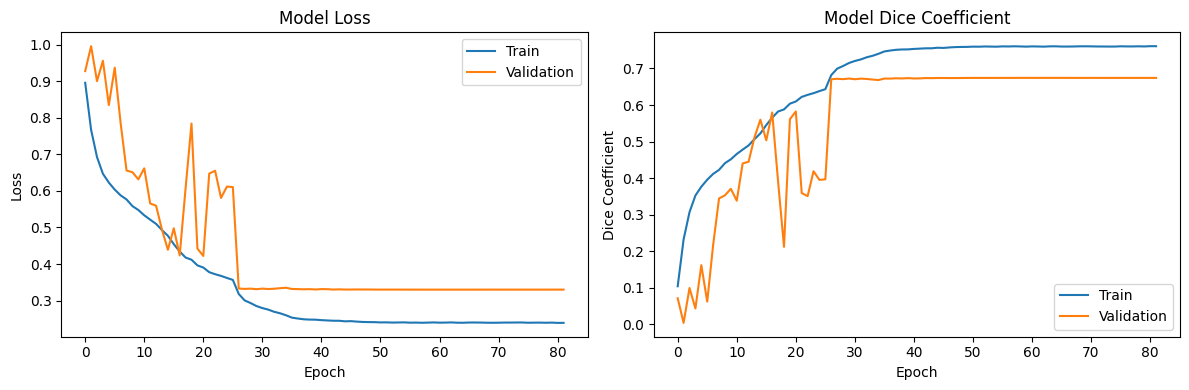

Training completed. Best model saved in 'output/best_model.keras'


In [21]:
# UNETR 2D Brain Tumor Segmentation Training Notebook

# Cell 1: Install Required Libraries and Check GPU
!pip install tensorflow patchify opencv-python-headless scikit-learn

import os
import numpy as np
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())

# Cell 2: Import Required Libraries
import os
import cv2
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from patchify import patchify

# Cell 3: Define Configuration
cf = {
    "image_size": 256,
    "num_channels": 3,
    "num_layers": 12,
    "hidden_dim": 128,
    "mlp_dim": 32,
    "num_heads": 6,
    "dropout_rate": 0.1,
    "patch_size": 16,
}
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

# Cell 4: Metrics Definition
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Cell 5: Model Architecture
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from math import log2

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    x = patch_embed + pos_embed

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2:
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)

    if upscale < 0:
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder blocks
    x = deconv_block(z12, 128)
    s = deconv_block(z9, 128)
    s = conv_block(s, 128)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    x = deconv_block(x, 64)
    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    x = deconv_block(x, 32)
    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    x = deconv_block(x, 16)
    s = conv_block(z0, 16)
    s = conv_block(s, 16)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

# Cell 6: Data Loading and Preprocessing Functions
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

# Cell 7: Dataset Preparation
# Assuming you've uploaded the dataset to /kaggle/input/brain-tumor-segmentation
dataset_path = "/kaggle/input/brain-tumor-segmentation"

X = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
Y = sorted(glob(os.path.join(dataset_path, "masks", "*.png")))

# Split data
train_x, temp_x, train_y, temp_y = train_test_split(X, Y, test_size=0.2, random_state=42)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)

print(f"Train: {len(train_x)}, Valid: {len(valid_x)}, Test: {len(test_x)}")

# Cell 8: Create Datasets
batch_size = 8
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# Cell 9: Model Training
# Hyperparameters
num_epochs = 100
lr = 1e-3  # Adjusted learning rate

# Create directories
create_dir("output")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build model
model = build_unetr_2d(cf)
model.compile(
    loss=dice_loss, 
    optimizer=Adam(learning_rate=lr), 
    metrics=[dice_coef, "accuracy"]
)

# Callbacks
callbacks = [
    ModelCheckpoint("output/best_model.keras", verbose=1, save_best_only=True, mode='min', monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger("output/training_log.csv"),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

# Cell 10: Visualize Training Results
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation dice coefficient
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.savefig('output/training_metrics.png')
plt.show()

print("Training completed. Best model saved in 'output/best_model.keras'")

In [28]:
import os
import numpy as np
import cv2
import tensorflow as tf
from patchify import patchify
# Include these functions directly in case you don't have metrics.py

# UNETR Configuration (Make sure this matches your model's configuration)
cf = {
    "image_size": 256,  # Input image size (must match the size the model was trained on)
    "num_channels": 3,  # Number of channels in the input (RGB)
    "patch_size": 16,   # Patch size used for the model
}
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

# Dice Coefficient and Loss Functions (copied from your training script)
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def load_and_preprocess_image(image_path):
    """ Load and preprocess the image (resize, normalize, patchify) """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0  # Normalize to [0, 1]

    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)  # Add batch dimension
    return patches

if __name__ == "__main__":
    # Set the paths
    model_path = "/kaggle/working/output/best_model.keras"  # Path to your trained model
    input_image_path = "/kaggle/input/brain-tumor-segmentation/images/1.png"  # Path to your test image
    output_mask_path = "/kaggle/working/output/predicted_mask.png"  # Path to save the predicted mask

    # Load the model
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

    # Load and preprocess the image
    input_patches = load_and_preprocess_image(input_image_path)

    # Make the prediction
    pred = model.predict(input_patches, verbose=0)[0]
    pred_resized = cv2.resize(pred, (cf["image_size"], cf["image_size"]))  # Resize to original image size
    pred_resized = np.where(pred_resized > 0.5, 1.0, 0.0)  # Binarize the prediction

    # Save the predicted mask
    cv2.imwrite(output_mask_path, pred_resized * 255)  # Save as an image (scaled by 255 for display purposes)

    print("Test completed. Predicted mask saved to:", output_mask_path)


Test completed. Predicted mask saved to: /kaggle/working/output/predicted_mask.png


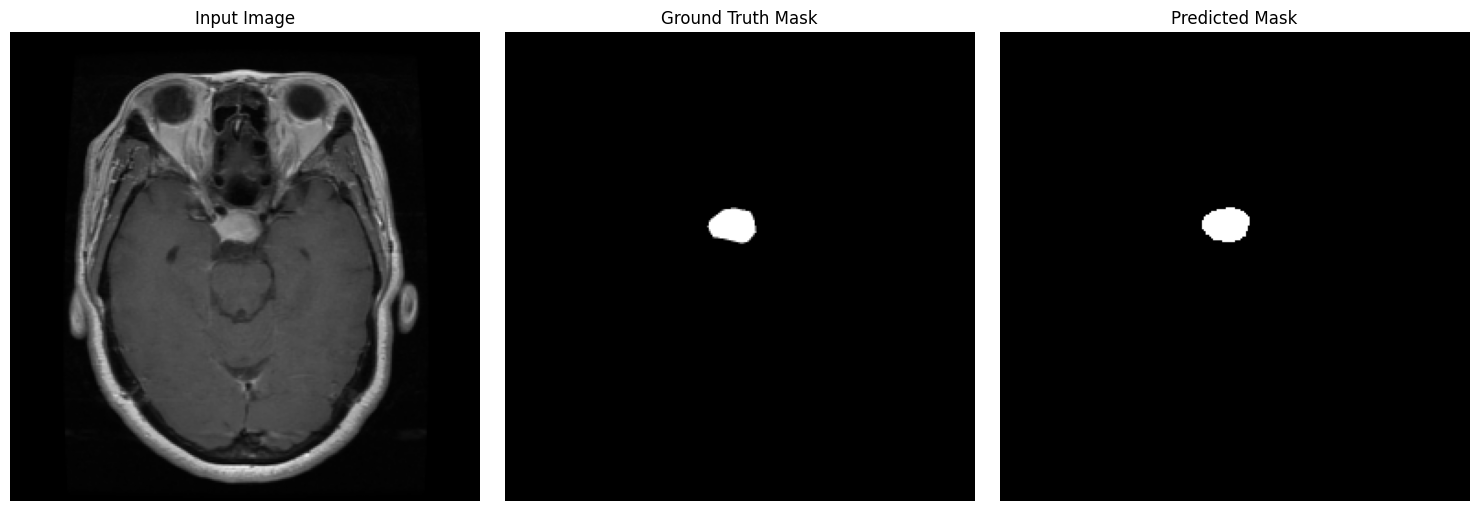

Test completed. Predicted mask displayed.


In [30]:
import os
import numpy as np
import cv2
import tensorflow as tf
from patchify import patchify
import matplotlib.pyplot as plt  # For displaying images in the notebook

# UNETR Configuration
cf = {
    "image_size": 256,  # Input image size (must match the size the model was trained on)
    "num_channels": 3,  # Number of channels in the input (RGB)
    "patch_size": 16,   # Patch size used for the model
}
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

# Dice Coefficient and Loss Functions (copied from your training script)
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def load_and_preprocess_image(image_path):
    """ Load and preprocess the image (resize, normalize, patchify) """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0  # Normalize to [0, 1]

    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)  # Add batch dimension
    return image, patches  # Return both the original image and the patches

def display_images(input_image, ground_truth_mask, predicted_mask):
    """ Display the input image, ground truth, and predicted mask side by side """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set the paths
    model_path = "/kaggle/working/output/best_model.keras"  # Path to your trained model
    image_path = "/kaggle/input/brain-tumor-segmentation/images/1009.png"  # Path to your test image
    ground_truth_path = "/kaggle/input/brain-tumor-segmentation/masks/1009.png"  # Path to the corresponding ground truth mask

    # Load the model
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

    # Load and preprocess the image and ground truth mask
    input_image, input_patches = load_and_preprocess_image(image_path)

    # Load the ground truth mask
    ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask = cv2.resize(ground_truth_mask, (cf["image_size"], cf["image_size"])) / 255.0  # Normalize to [0, 1]

    # Make the prediction
    pred = model.predict(input_patches, verbose=0)[0]
    pred_resized = cv2.resize(pred, (cf["image_size"], cf["image_size"]))  # Resize to original image size
    pred_resized = np.where(pred_resized > 0.5, 1.0, 0.0)  # Binarize the prediction

    # Display the images: input, ground truth, and predicted mask
    display_images(input_image, ground_truth_mask, pred_resized)

    print("Test completed. Predicted mask displayed.")
